# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import brfss

import thinkstats2
import thinkplot

## Scatter plots

I'll start with the data from the BRFSS again.

In [2]:
df = brfss.ReadBrfss(nrows=None)

The following function selects a random subset of a `DataFrame`.

In [3]:
def SampleRows(df, nrows, replace=False):
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

I'll extract the height in cm and the weight in kg of the respondents in the sample.

In [4]:
sample = SampleRows(df, 5000)
heights, weights = sample.htm3, sample.wtkg2

Here's a simple scatter plot with `alpha=1`, so each data point is fully saturated.

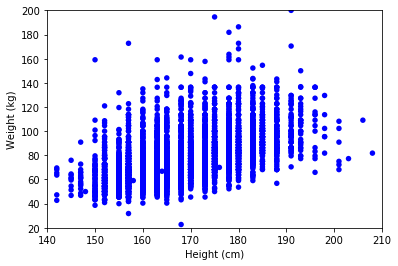

In [5]:
thinkplot.Scatter(heights, weights, alpha=1)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

The data fall in obvious columns because they were rounded off.  We can reduce this visual artifact by adding some random noice to the data.

NOTE: The version of `Jitter` in the book uses noise with a uniform distribution.  Here I am using a normal distribution.  The normal distribution does a better job of blurring artifacts, but the uniform distribution might be more true to the data.

In [6]:
def Jitter(values, jitter=0.5):
    n = len(values)
    return np.random.normal(0, jitter, n) + values

Heights were probably rounded off to the nearest inch, which is 2.8 cm, so I'll add random values from -1.4 to 1.4.

In [7]:
heights = Jitter(heights, 1.4)
weights = Jitter(weights, 0.5)

And here's what the jittered data look like.

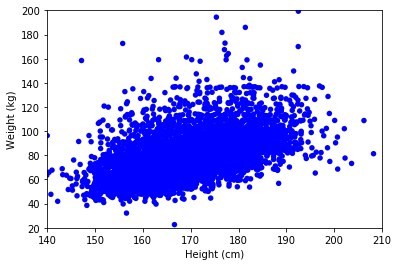

In [8]:
thinkplot.Scatter(heights, weights, alpha=1.0)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

The columns are gone, but now we have a different problem: saturation.  Where there are many overlapping points, the plot is not as dark as it should be, which means that the outliers are darker than they should be, which gives the impression that the data are more scattered than they actually are.

This is a surprisingly common problem, even in papers published in peer-reviewed journals.

We can usually solve the saturation problem by adjusting `alpha` and the size of the markers, `s`.

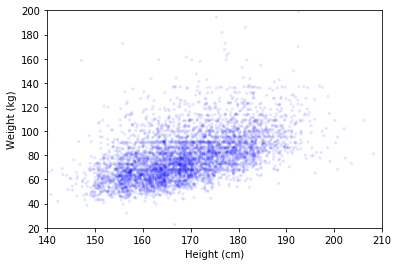

In [9]:
thinkplot.Scatter(heights, weights, alpha=0.1, s=10)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

That's better.  This version of the figure shows the location and shape of the distribution most accurately.  There are still some apparent columns and rows where, most likely, people reported their height and weight using rounded values.  If that effect is important, this figure makes it apparent; if it is not important, we could use more aggressive jittering to minimize it. 

An alternative to a scatter plot is something like a `HexBin` plot, which breaks the plane into bins, counts the number of respondents in each bin, and colors each bin in proportion to its count.

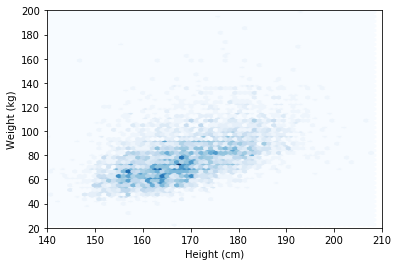

In [10]:
thinkplot.HexBin(heights, weights)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

In this case the binned plot does a pretty good job of showing the location and shape of the distribution.  It obscures the row and column effects, which may or may not be a good thing.

**Exercise:**  So far we have been working with a subset of only 5000 respondents.  When we include the entire dataset, making an effective scatterplot can be tricky.  As an exercise, experiment with `Scatter` and `HexBin` to make a plot that represents the entire dataset well.

In [11]:
# Solution goes here

## Plotting percentiles

Sometimes a better way to get a sense of the relationship between variables is to divide the dataset into groups using one variable, and then plot percentiles of the other variable.

First I'll drop any rows that are missing height or weight.

In [12]:
cleaned = df.dropna(subset=['htm3', 'wtkg2'])

Then I'll divide the dataset into groups by height.

In [13]:
bins = np.arange(135, 210, 5)
indices = np.digitize(cleaned.htm3, bins)
groups = cleaned.groupby(indices)

Here are the number of respondents in each group:

In [14]:
for i, group in groups:
    print(i, len(group))

0 305
1 228
2 477
3 2162
4 18759
5 45761
6 70610
7 72138
8 61725
9 49938
10 43555
11 20077
12 7784
13 1777
14 405
15 131


Now we can compute the CDF of weight within each group.

In [15]:
mean_heights = [group.htm3.mean() for i, group in groups]
cdfs = [thinkstats2.Cdf(group.wtkg2) for i, group in groups]

And then extract the 25th, 50th, and 75th percentile from each group.

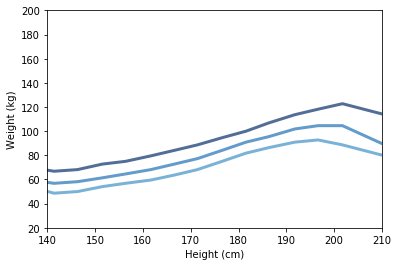

In [16]:
for percent in [75, 50, 25]:
    weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(mean_heights, weight_percentiles, label=label)
    
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

**Exercise:** Yet another option is to divide the dataset into groups and then plot the CDF for each group.  As an exercise, divide the dataset into a smaller number of groups and plot the CDF for each group.

In [17]:
# Solution goes here

## Correlation

The following function computes the covariance of two variables using NumPy's `dot` function.

In [18]:
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

And here's an example:

In [19]:
heights, weights = cleaned.htm3, cleaned.wtkg2
Cov(heights, weights)

103.3329085769776

Covariance is useful for some calculations, but it doesn't mean much by itself.  The coefficient of correlation is a standardized version of covariance that is easier to interpret.

In [20]:
def Corr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = thinkstats2.MeanVar(xs)
    meany, vary = thinkstats2.MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    return corr

The correlation of height and weight is about 0.51, which is a moderately strong correlation.

In [21]:
Corr(heights, weights)

0.5087364789734607

NumPy provides a function that computes correlations, too:

In [22]:
np.corrcoef(heights, weights)

array([[1.        , 0.50873648],
       [0.50873648, 1.        ]])

The result is a matrix with self-correlations on the diagonal (which are always 1), and cross-correlations on the off-diagonals (which are always symmetric).

Pearson's correlation is not robust in the presence of outliers, and it tends to underestimate the strength of non-linear relationships.

Spearman's correlation is more robust, and it can handle non-linear relationships as long as they are monotonic.  Here's a function that computes Spearman's correlation:

In [23]:
import pandas as pd

def SpearmanCorr(xs, ys):
    xranks = pd.Series(xs).rank()
    yranks = pd.Series(ys).rank()
    return Corr(xranks, yranks)

For heights and weights, Spearman's correlation is a little higher:

In [24]:
SpearmanCorr(heights, weights)

0.5405846262320476

A Pandas `Series` provides a method that computes correlations, and it offers `spearman` as one of the options.

In [25]:
def SpearmanCorr(xs, ys):
    xs = pd.Series(xs)
    ys = pd.Series(ys)
    return xs.corr(ys, method='spearman')

The result is the same as for the one we wrote.

In [26]:
SpearmanCorr(heights, weights)

0.5405846262320491

An alternative to Spearman's correlation is to transform one or both of the variables in a way that makes the relationship closer to linear, and the compute Pearson's correlation.

In [27]:
Corr(cleaned.htm3, np.log(cleaned.wtkg2))

0.5317282605983452

## Exercises

Using data from the NSFG, make a scatter plot of birth weight versus mother’s age. Plot percentiles of birth weight versus mother’s age. Compute Pearson’s and Spearman’s correlations. How would you characterize the relationship between these variables?

In [28]:
import first
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])

In [50]:
# review columns to find desired data

pd.options.display.max_columns = None
pd.options.display.max_rows = None

live.head(3)

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,cmotpreg,prgoutcome,cmprgend,flgdkmo1,cmprgbeg,ageatend,hpageend,gestasun_m,gestasun_w,wksgest,mosgest,dk1gest,dk2gest,dk3gest,bpa_bdscheck1,bpa_bdscheck2,bpa_bdscheck3,babysex,birthwgt_lb,birthwgt_oz,lobthwgt,babysex2,birthwgt_lb2,birthwgt_oz2,lobthwgt2,babysex3,birthwgt_lb3,birthwgt_oz3,lobthwgt3,cmbabdob,kidage,hpagelb,birthplc,paybirth1,paybirth2,paybirth3,knewpreg,trimestr,ltrimest,priorsmk,postsmks,npostsmk,getprena,bgnprena,pnctrim,lpnctri,workpreg,workborn,didwork,matweeks,weeksdk,matleave,matchfound,livehere,alivenow,cmkidied,cmkidlft,lastage,wherenow,legagree,parenend,anynurse,fedsolid,frsteatd_n,frsteatd_p,frsteatd,quitnurs,ageqtnur_n,ageqtnur_p,ageqtnur,matchfound2,livehere2,alivenow2,cmkidied2,cmkidlft2,lastage2,wherenow2,legagree2,parenend2,anynurse2,fedsolid2,frsteatd_n2,frsteatd_p2,frsteatd2,quitnurs2,ageqtnur_n2,ageqtnur_p2,ageqtnur2,matchfound3,livehere3,alivenow3,cmkidied3,cmkidlft3,lastage3,wherenow3,legagree3,parenend3,anynurse3,fedsolid3,frsteatd_n3,frsteatd_p3,frsteatd3,quitnurs3,ageqtnur_n3,ageqtnur_p3,ageqtnur3,cmlastlb,cmfstprg,cmlstprg,cmintstr,cmintfin,cmintstrop,cmintfinop,cmintstrcr,cmintfincr,evuseint,stopduse,whystopd,whatmeth01,whatmeth02,whatmeth03,whatmeth04,resnouse,wantbold,probbabe,cnfrmno,wantbld2,timingok,toosoon_n,toosoon_p,wthpart1,wthpart2,feelinpg,hpwnold,timokhp,cohpbeg,cohpend,tellfath,whentell,tryscale,wantscal,whyprg1,whyprg2,whynouse1,whynouse2,whynouse3,anyusint,prglngth,outcome,birthord,datend,agepreg,datecon,agecon,fmarout5,pmarpreg,rmarout6,fmarcon5,learnprg,pncarewk,paydeliv,lbw1,bfeedwks,maternlv,oldwantr,oldwantp,wantresp,wantpart,cmbirth,ager,agescrn,fmarital,rmarital,educat,hieduc,race,hispanic,hisprace,rcurpreg,pregnum,parity,insuranc,pubassis,poverty,laborfor,religion,metro,brnout,yrstrus,prglngth_i,outcome_i,birthord_i,datend_i,agepreg_i,datecon_i,agecon_i,fmarout5_i,pmarpreg_i,rmarout6_i,fmarcon5_i,learnprg_i,pncarewk_i,paydeliv_i,lbw1_i,bfeedwks_i,maternlv_i,oldwantr_i,oldwantp_i,wantresp_i,wantpart_i,ager_i,fmarital_i,rmarital_i,educat_i,hieduc_i,race_i,hispanic_i,hisprace_i,rcurpreg_i,pregnum_i,parity_i,insuranc_i,pubassis_i,poverty_i,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,NaN,1.0,1093.0,NaN,1084.0,NaN,NaN,9.0,0.0,39.0,9.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0,8.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1093.0,138.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1166.0,1093.0,1166.0,920.0,1093.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,1.0,NaN,NaN,1,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,39,1,1.0,1093.0,33.16,1084,3241,1.0,2.0,1.0,1,NaN,NaN,NaN,2.0,995.0,NaN,1,2,1,2,695,44,44,1,1,16,12,2,2,2,2,2,2,2,2,469,3,2,1,5,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,8.8125
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,NaN,1.0,1166.0,NaN,1157.0,NaN,NaN,9.0,0.0,39.0,9.0,NaN,NaN,NaN,0.0,NaN,NaN,2.0,7.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1166.0,65.0,42.0,1.0,1.0,2.0,NaN,2.0,NaN,NaN,0.0,5.0,NaN,1.0,4.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,4.0,1.0,4.0,NaN,20.0,1.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1166.0,1093.0,1166.0,1093.0,1166.0,1166.0,1231.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,1.0,NaN,NaN,1,4.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,39,1,2.0,1166.0,39.25,1157,3850,1.0,2.0,1.0,1,2.0,4.0,3.0,2.0,87.0,0.0,1,4,1,4,695,44,44,1,1,16,12,2,2,2,2,2,2,

In [47]:
# set variables for age and birth weight

weight = live.totalwgt_lb
age = live.agepreg

''

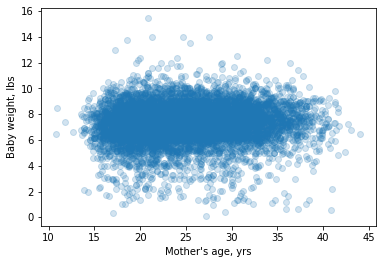

In [148]:
# scatterplot to initially visualize correlation

plt.scatter(age, weight, alpha = 0.2)
plt.xlabel("Mother's age, yrs")
plt.ylabel("Baby weight, lbs")
;

In [162]:
# group the data into bins based on age ranges (1 yr/bin)

bins = np.arange(15, 42, 1)
indices = np.digitize(age, bins)
groups = live.groupby(indices)

In [163]:
# print bins to see quantity of distrobution in each bin

for i, group in groups:
    print(i, len(group))

0 58
1 126
2 237
3 393
4 539
5 557
6 631
7 636
8 549
9 588
10 558
11 508
12 512
13 485
14 439
15 392
16 392
17 336
18 276
19 218
20 171
21 133
22 98
23 82
24 54
25 34
26 19
27 17


In [183]:
# use list comprehension to make list of mean age in each bin

mean_age = [group.agepreg.mean() for i, group in groups]

# then assign variable to cdf of binned data so that we can determine percentiles

cdfs = [thinkstats2.Cdf(group.totalwgt_lb) for i, group in groups]

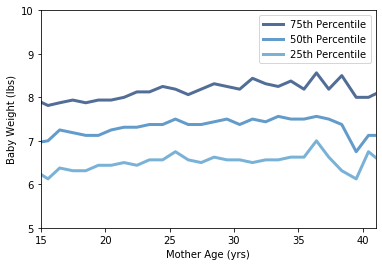

In [186]:
# iterate through list of percentile ranks to calculate and plot values at each rank in each bin

for percent in [75, 50, 25]:
    weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent + " Percentile"
    thinkplot.Plot(mean_age, weight_percentiles, label=label)
    
thinkplot.Config(xlabel='Mother Age (yrs)',
                 ylabel='Baby Weight (lbs)',
                 axis=[15, 41, 5, 10],
                 legend=True)

In [191]:
# calculate pearson's correlation

import math

cov = np.dot(age-age.mean(), weight-weight.mean()) / len(age)

p = cov / math.sqrt(age.var() * weight.var())

p

0.06882635429188806

In [193]:
# calculate Spearman's correlation

age.corr(weight, method='spearman')

0.09461004109658226

In [ ]:
# Based off the above plots and very low Pearson's and Spearman's correlation coefficients, we can determine that there is very low correlation between a mother's age and their child's birth weight. 